Choosing AR |B| threshold
---

In [1]:
from helpers_data import load_data, data_dir, get_ar_lats
from helpers_plot import figdir

from datetime import datetime
import glob

import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import numpy as np

Load magnetogram data
---

In [2]:
observatory = 'gong'
files = sorted(glob.glob(str(data_dir / f'{observatory}/20/*.npz')))
print(f"Found {len(files)} files")
print("Loading data...")
data = load_data(files)

Found 197 files
Loading data...
20060921
20061018
20061114
20061212
20210317
20210414
20210511


Load active region latitudes
---

In [3]:
lats_deg = get_ar_lats(data['time'].min().values,
                       data['time'].max().values)
ar_lats = np.sin(np.deg2rad(lats_deg))

Compute 2D histogram
---

In [7]:
bs = np.abs(data.loc['b_all'].values.reshape(data.shape[1], 180, 360).ravel())
lats_all = np.linspace(-1, 1, 181)
lats_all = (lats_all[1:] + lats_all[:-1]) / 2
lats_all = lats_all[np.newaxis, :, np.newaxis]
lats_all = np.repeat(lats_all, 360, axis=-1)
lats = np.repeat(lats_all, data.shape[1], axis=0).ravel()

# Calculate percentiles
lat_bins = np.linspace(-1, 1, 90)
pctiles = []
for ledge, redge in zip(lat_bins[:-1], lat_bins[1:]):
    # Filter < 3200 G to get rid of overflowed values in MDI magnetograms
    mask = (ledge < lats) & (lats < redge)#  & (bs < 3200)
    if bs[mask].size:
        pctiles.append(np.nanpercentile(bs[mask], [1, 99]))
    else:
        pctiles.append([np.nan, np.nan])

pctiles = np.array(pctiles)
# Calculate histogram
mask = np.isfinite(lats)
hist, xedges, yedges = np.histogram2d(lats[mask], bs[mask],
                      bins=(np.linspace(-1, 1, 181), np.logspace(-3, 3, 75)))
hist = hist.T / np.nanmax(hist, axis=1)

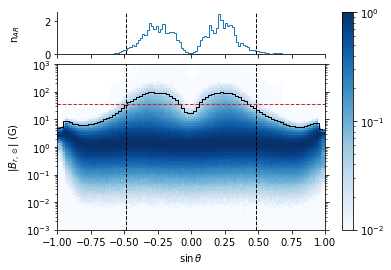

In [8]:
# Plot histogram
fig, axs = plt.subplots(nrows=2, sharex=True,
                        gridspec_kw={'height_ratios': [1, 4]})
ax = axs[1]
X, Y = np.meshgrid(xedges, yedges)
c = ax.pcolormesh(X, Y, hist, cmap='Blues', norm=mcolor.LogNorm(vmin=1e-2), edgecolors='face')
# Plot percentiles
# ax.step(lat_bins[:-1], pctiles[:, 0], where='post', color='k', lw=1)
ax.step(lat_bins[:-1], pctiles[:, 1], where='post', color='k', lw=1)
# Plot threshold
ax.axhline(35, color='tab:red', linestyle='--', linewidth=1)

ax.set_xlabel(r'$\sin \theta$')
ax.set_ylabel('|$B_{r,\odot}$| (G)')
ax.set_yscale('log')
ax.yaxis.set_ticks_position('both')


# Plot active regions
ax = axs[0]
ax.hist(ar_lats,
        bins=np.sin(np.deg2rad(np.linspace(-89.5, 89.5, 180))),
        histtype='step', density=True);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_ylabel('n$_{AR}$')
# ax.yaxis.set_ticks([])
for ax in axs:
    ax.axvline(np.nanpercentile(ar_lats, 1), lw=1, color='k', ls='--')
    ax.axvline(np.nanpercentile(ar_lats, 99), lw=1, color='k', ls='--')

fig.align_ylabels()
fig.subplots_adjust(hspace=0.1)
fig.colorbar(c, ax=axs)
fig.savefig(f'figs/b_threshold_{observatory}.pdf', bbox_inches='tight')